# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [24]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

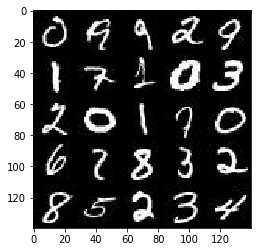

In [25]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

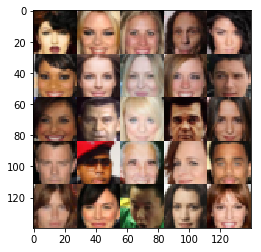

In [26]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [28]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [54]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer 1
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        #print ('Layer 1:', lrelu1.shape)
        # 14x14x64 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=1, padding="SAME",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 14x14x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="SAME", 
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', lrelu3.shape)
        #7x7x256 now
        
        flat = tf.reshape(lrelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function 
        
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        h1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        #print ('Layer 1:', lrelu1.shape)
        # 4x4x256 now
        
        # Hidden Layer 2
        h2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=1, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        #print ('Layer 2:', lrelu2.shape)
        # 8x8x128 now
        
        # Hidden Layer 3
        h3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #print ('Layer 3:', h3.shape)
        # 16x16x64
        
        # Output layer, 28x28x5
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)
        #print ('Output:', logits.shape)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [56]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    smooth = 0.1
    
    # Generator network 
    g_model = generator(input_z, out_channel_dim, is_train=True)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
     labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
     labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [57]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    
    # https://blog.metaflow.fr/tensorflow-mutating-variables-and-control-flow-2181dd238e62
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [59]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model   
    
    # Set the image width, height, and image channels
    _, image_width, image_height, image_channels = data_shape
    
    # Impliment model_inputs and set the input_real, input_z, and learning rate
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Impliment model_loss and set the d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Impliment model_opt and set d_train_opt and g_train_opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set batch counter
    batch_count = 0
    
    # Set number of images to print
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Multiply batch_images by 2.0 since the dataset ranges from -0.5 to 0.5
                batch_images = batch_images*2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                # Increment the batch_count
                batch_count += 1

                # Print the d_train_loss and g_train_loss every 10 batches
                if (batch_count % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output every 100 batches
                if (batch_count % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4509... Generator Loss: 2.5297
Epoch 1/2... Discriminator Loss: 0.4946... Generator Loss: 2.3184
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.9854
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 1.0129
Epoch 1/2... Discriminator Loss: 0.8258... Generator Loss: 2.0823
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 3.0280
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.2895
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.4693


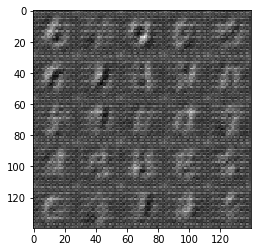

Epoch 1/2... Discriminator Loss: 1.6109... Generator Loss: 0.4113
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.7927
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.3769
Epoch 1/2... Discriminator Loss: 1.4780... Generator Loss: 0.4762
Epoch 1/2... Discriminator Loss: 0.7777... Generator Loss: 1.7346
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.9631... Generator Loss: 0.3133
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 2.7687
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 1.4109
Epoch 1/2... Discriminator Loss: 0.7397... Generator Loss: 1.3286


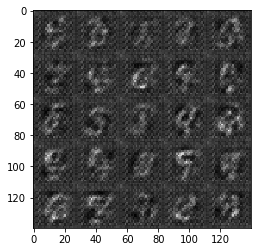

Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 2.0040
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 1.3442
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.1145
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.4855
Epoch 1/2... Discriminator Loss: 0.8381... Generator Loss: 3.0945
Epoch 1/2... Discriminator Loss: 0.6768... Generator Loss: 2.0728
Epoch 1/2... Discriminator Loss: 0.6557... Generator Loss: 2.1440
Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 1.3613
Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 1.9761
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 1.2019


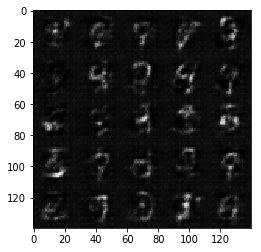

Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 1.2564
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 2.2946
Epoch 1/2... Discriminator Loss: 0.6665... Generator Loss: 2.4520
Epoch 1/2... Discriminator Loss: 0.6589... Generator Loss: 1.4961
Epoch 1/2... Discriminator Loss: 0.5823... Generator Loss: 2.8657
Epoch 1/2... Discriminator Loss: 0.5863... Generator Loss: 1.8213
Epoch 1/2... Discriminator Loss: 0.6730... Generator Loss: 1.9045
Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 2.5414
Epoch 1/2... Discriminator Loss: 0.5770... Generator Loss: 1.7960
Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 0.9190


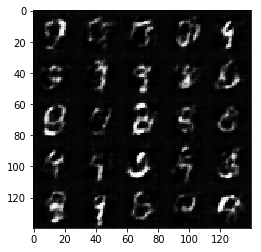

Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 1.7979
Epoch 1/2... Discriminator Loss: 0.7419... Generator Loss: 2.9403
Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 1.6615
Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 1.7792
Epoch 1/2... Discriminator Loss: 0.6485... Generator Loss: 2.3104
Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 2.6233
Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 2.0621
Epoch 1/2... Discriminator Loss: 0.5986... Generator Loss: 1.8036
Epoch 1/2... Discriminator Loss: 0.6611... Generator Loss: 1.5809


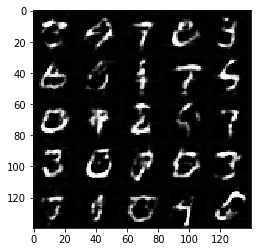

Epoch 1/2... Discriminator Loss: 0.5714... Generator Loss: 1.9321
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 2.8806
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 2.1994
Epoch 1/2... Discriminator Loss: 2.5916... Generator Loss: 5.8785
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 1.0183
Epoch 1/2... Discriminator Loss: 0.6060... Generator Loss: 2.1708
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 1.6933
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 0.9160


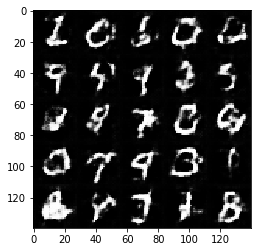

Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 1.4654
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.3978
Epoch 1/2... Discriminator Loss: 0.7828... Generator Loss: 2.4157
Epoch 1/2... Discriminator Loss: 0.5797... Generator Loss: 1.9747
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 0.8892... Generator Loss: 2.8745
Epoch 1/2... Discriminator Loss: 0.8510... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 1.1569
Epoch 1/2... Discriminator Loss: 2.2189... Generator Loss: 0.2347
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 1.9507


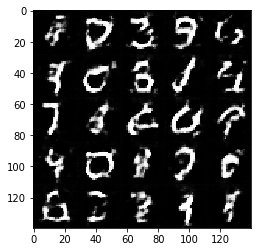

Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 1.6589
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.9049
Epoch 1/2... Discriminator Loss: 0.7244... Generator Loss: 1.4396
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.0214
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 2.3861
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 3.1573
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 0.7647... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 1.7022


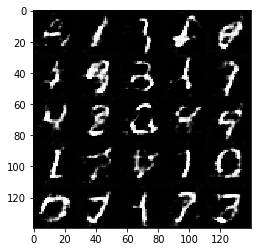

Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.6617
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 1.5455
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 1.5863
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 1.0101
Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.4188
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.0682
Epoch 1/2... Discriminator Loss: 0.7711... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 1.6274
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.7536


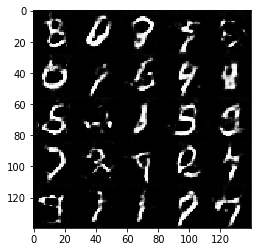

Epoch 1/2... Discriminator Loss: 0.7563... Generator Loss: 1.9012
Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 1.5324
Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 2.4541
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 0.9803
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 2.0356
Epoch 2/2... Discriminator Loss: 1.6890... Generator Loss: 3.4983
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.1095
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 1.5261
Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.2884


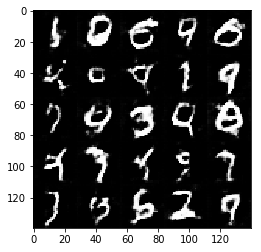

Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.7635
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.6871
Epoch 2/2... Discriminator Loss: 1.5450... Generator Loss: 0.5547
Epoch 2/2... Discriminator Loss: 0.9026... Generator Loss: 1.4729
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.5349
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 1.1857
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 0.9451
Epoch 2/2... Discriminator Loss: 0.7377... Generator Loss: 1.4815
Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 2.3758


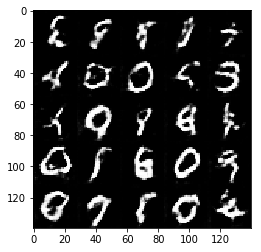

Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 1.5230
Epoch 2/2... Discriminator Loss: 1.0429... Generator Loss: 2.1802
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.5733
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 1.2786
Epoch 2/2... Discriminator Loss: 0.7671... Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 2.7042
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 1.1202
Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 1.1123
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 1.0858


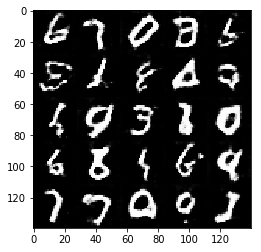

Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.1439
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 1.4035
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.3486
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 1.4910
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.5451
Epoch 2/2... Discriminator Loss: 1.0412... Generator Loss: 0.8254
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.8993
Epoch 2/2... Discriminator Loss: 2.5540... Generator Loss: 0.1826


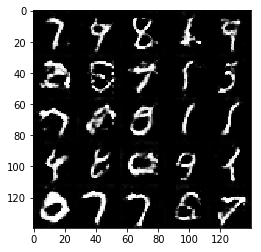

Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.6807
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.8010
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.5180
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.0295
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 1.4410
Epoch 2/2... Discriminator Loss: 0.6600... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 0.6979... Generator Loss: 1.8397
Epoch 2/2... Discriminator Loss: 1.0024... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 1.7546
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 1.7977


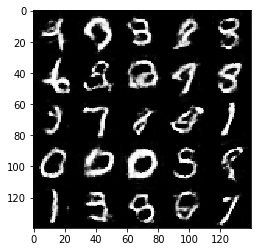

Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 1.4642
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.7410
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.3031
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.3105
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.5750
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.6529
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 1.3455


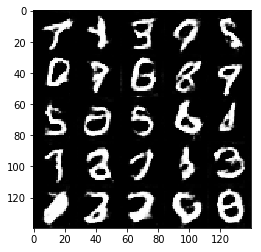

Epoch 2/2... Discriminator Loss: 1.2206... Generator Loss: 0.8318
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 1.4566
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 1.1323
Epoch 2/2... Discriminator Loss: 0.8163... Generator Loss: 1.6593
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.6552
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.8854
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.4462
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 0.9826


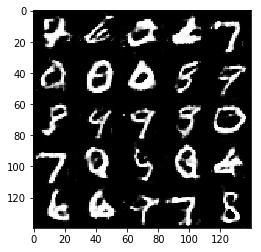

Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.7495
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 1.0488
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.7637
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 2.0447
Epoch 2/2... Discriminator Loss: 0.6107... Generator Loss: 2.0525
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 1.4487
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.1668


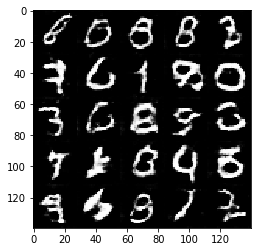

Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 1.7754
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.1473
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.7650
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.4622
Epoch 2/2... Discriminator Loss: 0.8216... Generator Loss: 1.8282
Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 2.0264
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.2609
Epoch 2/2... Discriminator Loss: 3.5800... Generator Loss: 4.5366
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.3033


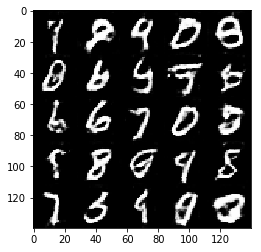

Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.3661
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 1.1522
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 0.9165
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 2.8162
Epoch 2/2... Discriminator Loss: 0.8396... Generator Loss: 1.1753
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 1.3674
Epoch 2/2... Discriminator Loss: 1.5758... Generator Loss: 0.5079


In [60]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.5483... Generator Loss: 2.0615
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 2.8099
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 3.0276
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 2.3819
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 3.7779
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 3.0244
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.8405
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.9502


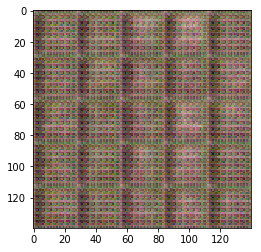

Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.4339
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.6724
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 2.4287
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.7912
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 2.3259
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.6864
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.3126


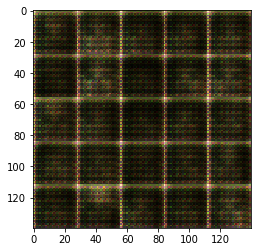

Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.4338
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.7351
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 1.8093
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 2.9047
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 2.4687
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 3.0901
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 1.5432
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.3181
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 2.1832
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 4.9566


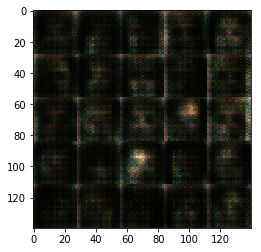

Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 2.3879
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 2.5360
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 3.1780
Epoch 1/1... Discriminator Loss: 0.6267... Generator Loss: 2.6243
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 3.5654
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 2.1690
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 2.3740
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.5722


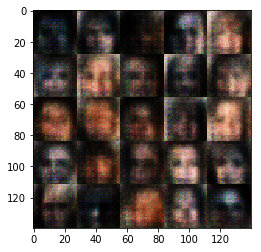

Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 1.5822
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 2.3391
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.8331
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.8409
Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.4594
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.1686


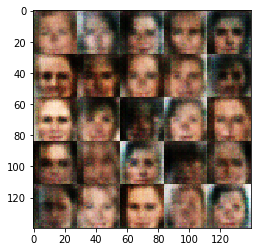

Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.5759
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 2.1803
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 2.2791
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 2.2448
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.4687


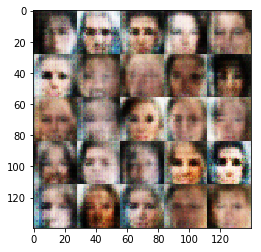

Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 2.1577
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 3.2073
Epoch 1/1... Discriminator Loss: 0.8612... Generator Loss: 1.8205
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.3916
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 2.0237
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.6423
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 2.3946


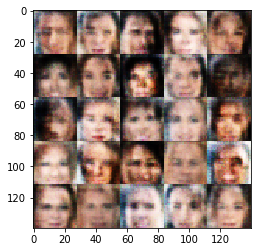

Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.8216
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 2.1024
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.4399
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.9254


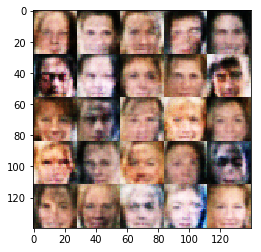

Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.9857
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 3.2025
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 2.1562
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.3190


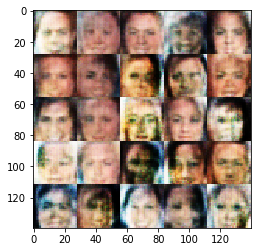

Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.2849
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 2.1482
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 2.4163
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 0.8212... Generator Loss: 1.8090


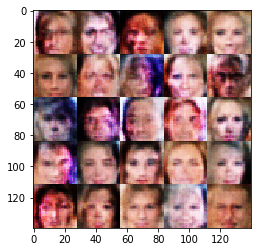

Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 2.0689
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 2.4512
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.6870
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.6803
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.4544
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.5156
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.6143


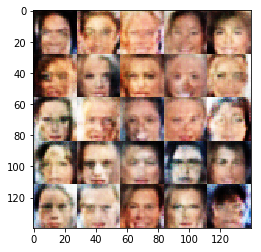

Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 2.1489
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 2.6358
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.4558


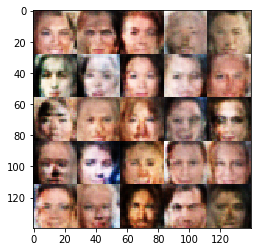

Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.8674
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 2.0267
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.4500
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.8982


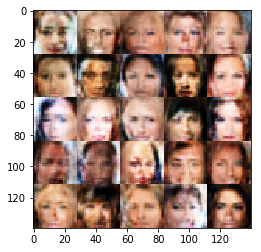

Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.7475
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.4732
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 2.3724
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.5643
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.4807


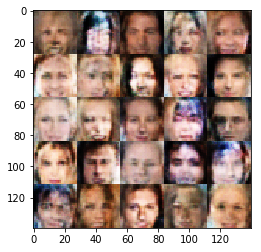

Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.3907
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.5726
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 2.3271
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.7505
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.3212
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8244


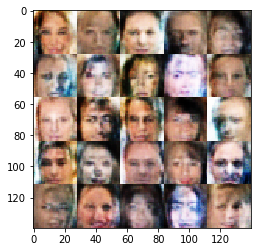

Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.9456
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.6123
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 2.1864
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 2.0280


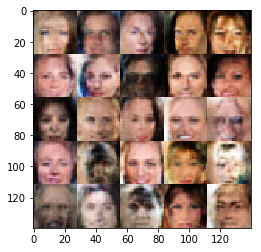

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 2.2206
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 1.6758
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.8068


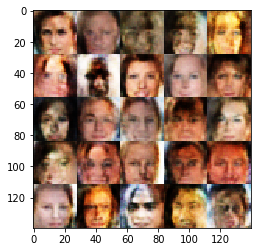

Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 0.9779
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.2118
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.8862


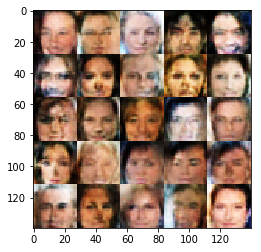

Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 2.0569
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.9561
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.5353


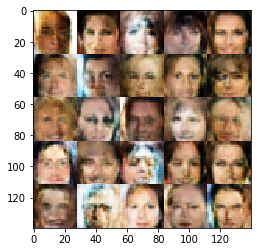

Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.5222
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.4136
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.6428
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.8680


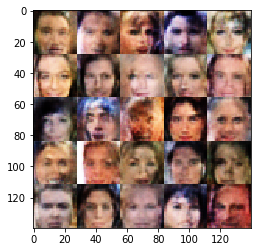

Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 2.8651
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 2.1516
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.7252
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 0.8093... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.3302


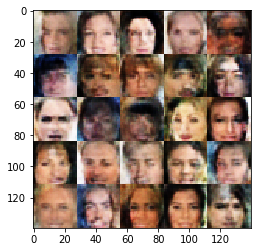

Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 2.0877
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 0.7405... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 2.2180


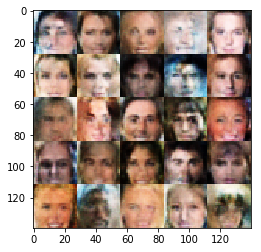

Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.6244
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.4679
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.3311


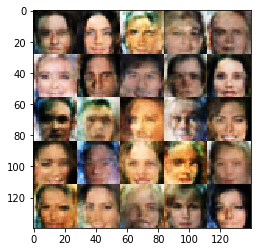

Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.0804


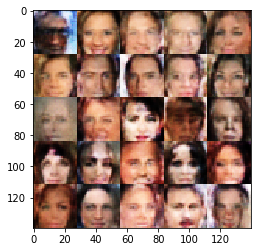

Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.3836
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 1.2860


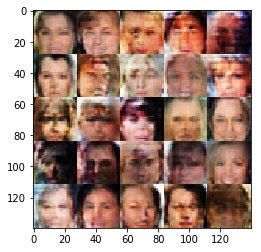

Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.9073... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.7359
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.6489


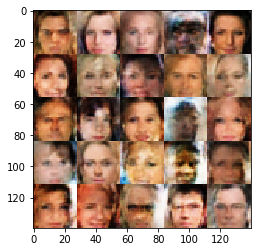

Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 0.8456... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.4478


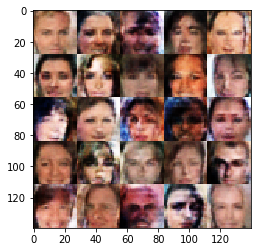

Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 2.2660
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.6010
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.7359
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.6592
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.7737
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.8687


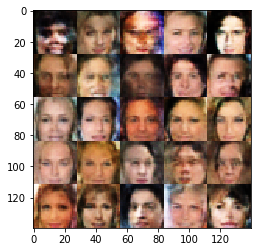

Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.8417
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 2.0761
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.7755


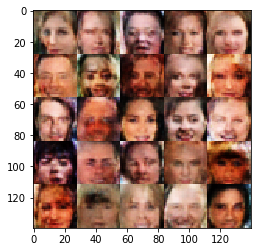

Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 0.8683... Generator Loss: 1.2933
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.4183
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.9115... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.3578


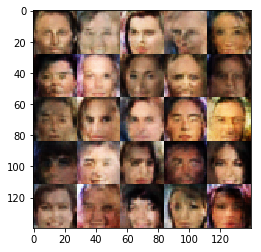

Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.6527
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.5410
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 1.5461


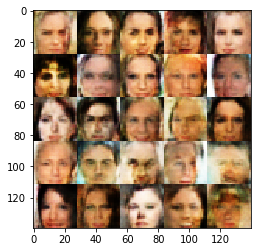

Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.6077
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.7625


In [62]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.